# POA Transposition Model Validation
The purpose of this notebook is to validate the use of new or current POA transposition models through multiple steps of analysis. \
\
The model input data comes from the published results of the 2021 Blind Modeling Comparison. In the following notebook the data collected in S2 is used, which is from the Canadian Solar 275W system at Sandia National Labs in Albuquerque, NM from  Jan 2021 - Dec 2021. More information about the dataset can be found at the [DuraMAT Data Hub](https://datahub.duramat.org/dataset/pv-performance-modeling-data/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5) and the [published results of the 2021 Blind Modeling Comparison](https://onlinelibrary.wiley.com/doi/pdf/10.1002/pip.3729) \
\
To demonstrate the way this notebook should work, a pvlib-python model, specifically Perez, is used in place of a user defind model. To use this notebook for a custom model, simply replace the Perez model defined in _3: Run model to be validated or import model results_. If the model is run by an external program, it is also possible to import only the results to use in the validation and analysis. \
\
The notebook is segemented into 4 sections:

<li><b>1. Import data from DuraMAT</b></li>
<li><b>2. Define relevant system & meteo data</b></li>
<li><b>3. Run model to be validated or import model results</b></li>
<li><b>4. Compare model to measured results and other baseline models</b></li>

In [1]:
#import necessary packages and set default formatting for plots

import matplotlib as mpl #v. 3.7.2
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np #v. 1.24.3
import seaborn as sns #v 0.12.2
import pandas as pd #v. 2.0.3
pd.options.mode.chained_assignment = None
import pvlib #v. 0.9.3
import pvanalytics #v 0.1.3
import sklearn.metrics #v. 1.3.0
import scipy #v. 1.11.1
from tabulate import tabulate #v. 0.8.10

#plotting format
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size']=12
plt.rcParams['lines.linewidth']=1.25
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.titlesize']=12

## 1. Import data

This section imports the meteo and system data from the DuraMAT Datahub. For the purpose of accurate solar position calculations, the times are set to be labeled at the middle-of-hour. The data includes 2 filters: _bsrn pass_ and _SNL No Snow_. The baseline surface radiation network (BSRN) filter follows [version 2 quality control tests](https://epic.awi.de/id/eprint/30083/1/BSRN_recommended_QC_tests_V2.pdf) and the SNL No Snow filter removes any days with recorded snow fall or snow depth. Data is removed if either filter value is '0'. For the meteo data, any 0 values are replaced with NaNs so that statistical values, like mean, are not affected by these values. 

In [2]:
#read in data from duramat data hub directly

#on SRN
df = pd.read_excel('pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx', sheet_name='S2')

#off SRN
#df = pd.read_excel(https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx,
#                   sheet_name='S2'

#Reassigning the index so the timesteps are at the middle of the hour
df.index = pd.date_range(start='2021-01-01 00:30:00', end='2021-12-31 23:30:00', freq='H')
df.index = df.index.tz_localize('MST')

#apply the filters that are included in the data & replacing any 0 with nan so they dont affect error metrics
#dropping nans helps keep size down so operations run more quickly and smoothly
df = df.where((df['bsrn_pass'] == 1) & (df['SNL No Snow'] == 1)).dropna()
df.replace(0, np.nan, inplace=True)
df.dropna(inplace=True)

df.head()

,Scenario,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),Measured front POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),bsrn_pass,SNL No Snow
2021-01-01 08:30:00-07:00,S2,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,442.132104,6.645174,1292.814741,1.0,1.0
2021-01-01 09:30:00-07:00,S2,2020.0,1.0,1.0,10.0,353.666975,914.471581,40.138926,-0.708700,41.447333,2.923567,701.031595,17.712519,2276.603041,1.0,1.0
2021-01-01 10:30:00-07:00,S2,2020.0,1.0,1.0,11.0,482.624408,978.551782,44.586906,0.819633,38.089500,2.962067,879.164182,25.669461,2782.780150,1.0,1.0
2021-01-01 11:30:00-07:00,S2,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,977.788429,35.226433,2989.486270,1.0,1.0
2021-01-01 12:30:00-07:00,S2,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,922.354253,38.056121,2796.495393,1.0,1.0


## 2. Define system and meteo data
'module' is a dictionary of module specific values for 275 W mono-Si Canadian Solar modules and includes system and module data. All data for this system can be found in the various reports on the [PVPMC Wesbite](https://pvpmc.sandia.gov/pv-research/pv-lifetime-project/pv-lifetime-modules/). Solar position calculations generate azimuth, zenith, elevation, etc for every timestep in the df

In [3]:
#Defining constants and values that are consistent across all calculations
#we are using S2 from the data, which is the Candian Solar Monocrystalline 275W module
module = {'Tilt': 35,'Latitude': 35.05,'Longitude': -106.54,'Altitude': 1600,'Surface Azimuth': 180,'String Length':12, 'iam0':1,'iam10': 0.9989, 'iam20': 1.0014, 'iam30': 1.0002, 'iam40':0.9984, 
          'iam45': 0.9941, 'iam50': 0.9911, 'iam55': 0.9815, 'iam60':0.9631, 'iam65':0.9352, 'iam70':0.8922, 'iam75':0.8134, 'iam80':0.6778, 'iam85': 0.4351,
         'U0': 28.825, 'U1': 4.452, 'NOCT': 45, 'Unit Mass': 11.119, 'Area':1.621, 'Pmp' : 275, 'Gamma Pmp': -0.0041, 'Alpha Isc':0.0033,
          'Beta Voc': -0.1178, 'Cell Type':'monoSi', 'Cells in Series':60}
module = pd.Series(module)

#Running solar position calculations
spdf = pvlib.solarposition.get_solarposition(time=df.index, latitude=module['Latitude'], 
        longitude=module['Longitude'],temperature=df['Ambient Temp (°C) '], altitude=module['Altitude'])
spdf['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=df.index)
pres = pvlib.atmosphere.alt2pres(module['Altitude'])

#Save these values into the df with inputs & results for use in later analysis
df['Azimuth'] = spdf['azimuth']
df['Zenith'] = spdf['apparent_zenith']
df['Sol Elev'] = spdf['elevation']
df['AOI'] = pvlib.irradiance.aoi(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'],solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'])
df['Airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=spdf['apparent_zenith'])
df['Clearness Index'] = pvlib.irradiance.clearness_index(ghi=df['GHI (W/m2)'], solar_zenith=spdf['apparent_zenith'], extra_radiation = spdf['dni_extra'])
spdf.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,dni_extra
2021-01-01 08:30:00-07:00,77.884310,77.950122,12.115690,12.049878,129.546848,-3.734135,1413.981805
2021-01-01 09:30:00-07:00,69.241432,69.279260,20.758568,20.720740,140.756151,-3.753597,1413.981805
2021-01-01 10:30:00-07:00,62.615700,62.643406,27.384300,27.356594,154.026282,-3.773049,1413.981805
2021-01-01 11:30:00-07:00,58.731118,58.754688,31.268882,31.245312,169.230769,-3.792492,1413.981805
2021-01-01 12:30:00-07:00,58.153100,58.176057,31.846900,31.823943,185.427677,-3.811925,1413.981805


## 3. Run the model or import the results to be validated
A model can either be defined and run within this notebook or could be run externally and the results imported below. For demonstration purposes the `pvlib.irradiance.get_total_irradiance` function with the Perez model is used but should be replaced by the user's model. 

In [4]:
#Either run a model in this notebook or import the results into the column name below

#run model here --- this would be replaced by the user's model to be validated but for demonstration purposes a pvlib model is used here
df['Modeled POA'] = pvlib.irradiance.get_total_irradiance(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
                    solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'],dni=df['DNI (W/m2)'],
                    ghi=df['GHI (W/m2)'], dhi=df['DHI (W/m2)'], dni_extra=spdf['dni_extra'], model ='perez', model_perez='albuquerque1988')['poa_global']

# or import model results here. Make sure timestamps line up and are middle-of-hour
# df['Modeled POA'] = pd.read_excel('results.xlsx')

#specify a model name for use in analysis and plotting
model_name = 'Perez'

### Visualize the results of the model over a sample day 
This preliminary check helps make sure the results are feasible and there aren't any obvious errors like time shifts or magnitude differences

Text(0.5, 0, 'Time')

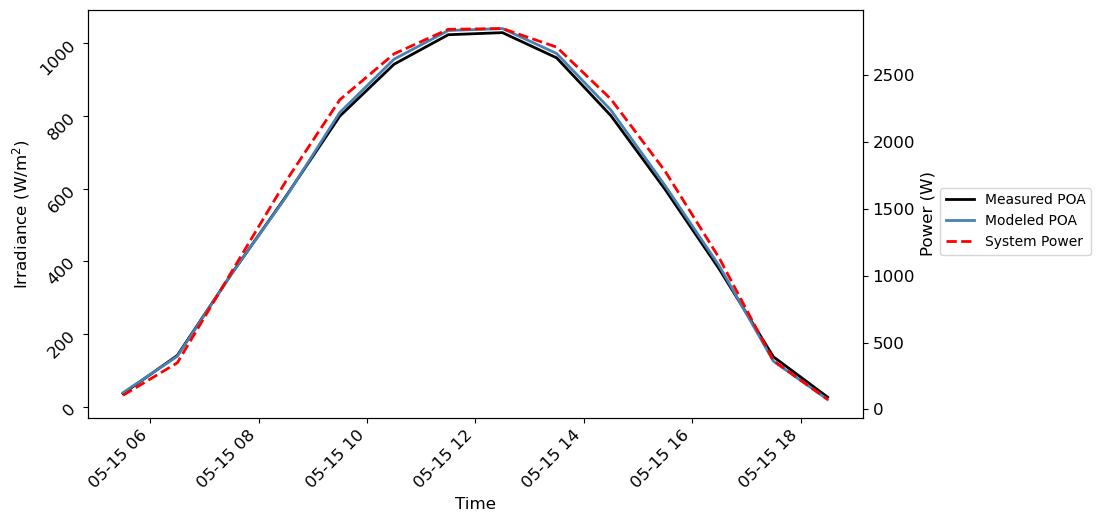

In [5]:
#diurnal plot
date = '2021-05-15'
fig, ax = plt.subplots()
ax2 = ax.twinx()
df.loc[date, 'Measured front POA irradiance (W/m2)'].plot(ax=ax, label='Measured POA', linewidth=2, color='black', zorder=5.5)
df.loc[date, 'Modeled POA'].plot(ax=ax, label='Modeled POA', linewidth=2, color='steelblue', zorder=5.5)
df.loc[date, 'Measured DC power (W)'].plot(ax=ax2, label='Measured DC Power', linewidth=2, color='red', zorder=2.5, linestyle='dashed')

line_1 = Line2D([0], [0], color='black', linewidth=2, linestyle='-',label='Measured POA')
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Modeled POA')
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label='System Power')
lines = [line_1,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.1, 0.4],handles=lines)
ax2.set_ylabel('Power (W)')
ax.tick_params(labelrotation=45)
ax.set_ylabel('Irradiance (W/m$^2$)')
ax.set_xlabel('Time')

## 4. Compare modeled values to measured values + other baseline models

### 3 steps of analysis:
<li><b>1. Overall NMBE, MBE, RMSE, NRMSE, and other errors of the model</b></li>
<li><b>2. Residual analysis</b></li>
<li><b>3. Comparison to baseline model</b></li>

### Analysis I: Overall errors of the model
#### • Normalized Mean Bias Error (NMBE) - shows the estimation bias of the model
###                 $100 * \frac{V_{modeled} - V_{measured}}{V_{measured}}$


#### • Root Mean Squared Error (RMSE) - measures average difference between modeled and measured values
### $ \sqrt{\frac{1}{N} \sum_{i=1}^{N}(V_{modeled}-V_{measured})^2} $

In [6]:
df['NBE'] = 100 * (df['Modeled POA'] - df['Measured front POA irradiance (W/m2)'])/(df['Measured front POA irradiance (W/m2)'])
nmbe = df['NBE'].mean()
df['BE'] = (df['Modeled POA'] - df['Measured front POA irradiance (W/m2)'])
mbe = df['BE'].mean()
rmse = sklearn.metrics.mean_squared_error(df.dropna()['Modeled POA'],df.dropna()['Measured front POA irradiance (W/m2)'], squared=False)
nrmse = 100 * rmse/(df['Measured front POA irradiance (W/m2)'].mean())
#print these in a neat table 
d = [['NMBE', str(round(nmbe,3))+' %'], ['MBE', str(round(mbe,3))+' W/m2'], ['NRMSE', str(round(nrmse,3))+' %'], ['RMSE',str(round(rmse,3))+' W/m2']]
print (tabulate(d, headers=["Metric", "Value"]))

Metric    Value
--------  -----------
NMBE      -0.769 %
MBE       3.674 W/m2
NRMSE     2.197 %
RMSE      12.675 W/m2


### Plotting the measured vs modeled values
The plot should be mostly linear. r and slope values close to one indicate good correlation and accurate model performance

Text(0.5, 1.0, 'Measured vs Modeled Values')

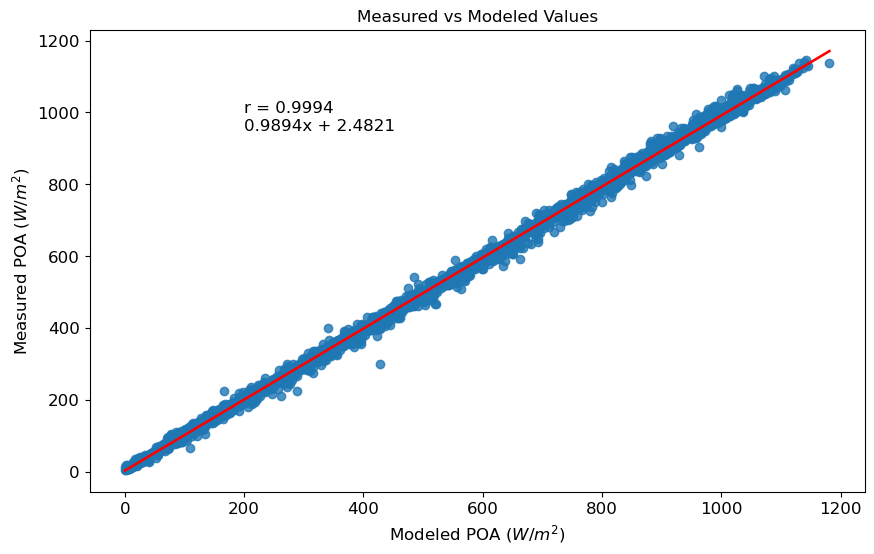

In [7]:
slope, intercept, r, p, std = scipy.stats.linregress(x = df.dropna()['Modeled POA'], y = df.dropna()['Measured front POA irradiance (W/m2)'])
sns.regplot(x = df['Modeled POA'], y = df['Measured front POA irradiance (W/m2)'], line_kws={'color':'red'})

plt.ylabel('Measured POA ($W/m^2$)')
plt.xlabel('Modeled POA ($W/m^2$)')
plt.text(200, 1000, s = ("r = "+str(round(r,4))))
plt.text(200, 950, s = (str(round(slope,4))+'x + '+str(round(intercept,4))))
plt.title('Measured vs Modeled Values')

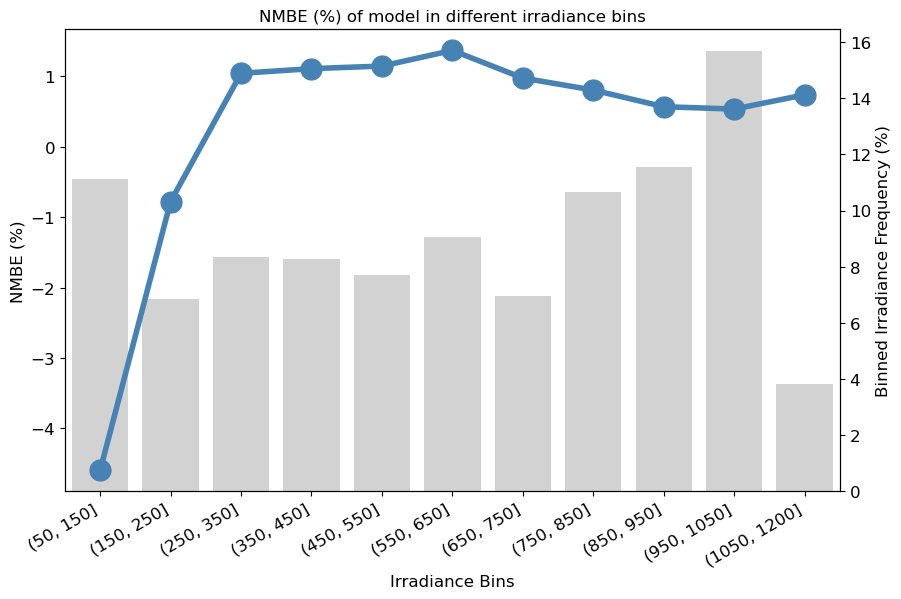

In [8]:
#plotting NMBE for each irradiance bin to see performance at different irradiance levels

df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins = bins.rename(columns = {'count':'Frequency'})
bins['Irradiance Bins'] = bins.index
bins.index.names = ['Index']
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
y = df[['Irradiance Bins','NBE']].groupby('Irradiance Bins').mean().sort_values('Irradiance Bins')['NBE']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=4, markersize=15)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('NMBE (%)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, errorbar=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plt.title('NMBE (%) of model in different irradiance bins')
plt.show()


### Energy Yield Estimates
We can run two simulations, one using the POA model and another using true POA data to see how much influence the errors of the model have on the predicted overall energy yield

In [9]:
## note: Typically, performance models use effective irradiance, which requires the various components of POA to calculate. 
#        Since the only measured POA data available to us is global (no diffuse/direct), we will not calculate effective irradiance and instead use our measured & modeled POA. 

#using measured POA to estimate energy
df['DC Power - Meas POA'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Measured front POA irradiance (W/m2)'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], df['Measured front POA irradiance (W/m2)'], deltaT=3),
                                    pdc0=275, gamma_pdc=-0.0041)
#using modeled POA to estimate energy
df['DC Power - Model POA'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Modeled POA'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], df['Modeled POA'], deltaT=3),
                                    pdc0=275, gamma_pdc=-0.0041)
#find overall % diff for annual energy
print('With measured POA, predicted annual energy is', round(df['DC Power - Meas POA'].sum()/1000,3),
      'kWh and with modeled POA, predicted annual energy is', round(df['DC Power - Model POA'].sum()/1000,3), 'kWh')
print('The % difference in energy estimate when using measured vs modeled POA is ', round(((df['DC Power - Model POA'].sum()-df['DC Power - Meas POA'].sum())/df['DC Power - Meas POA'].sum())*100,3),'%')

With measured POA, predicted annual energy is 6739.188 kWh and with modeled POA, predicted annual energy is 6780.385 kWh
The % difference in energy estimate when using measured vs modeled POA is  0.611 %


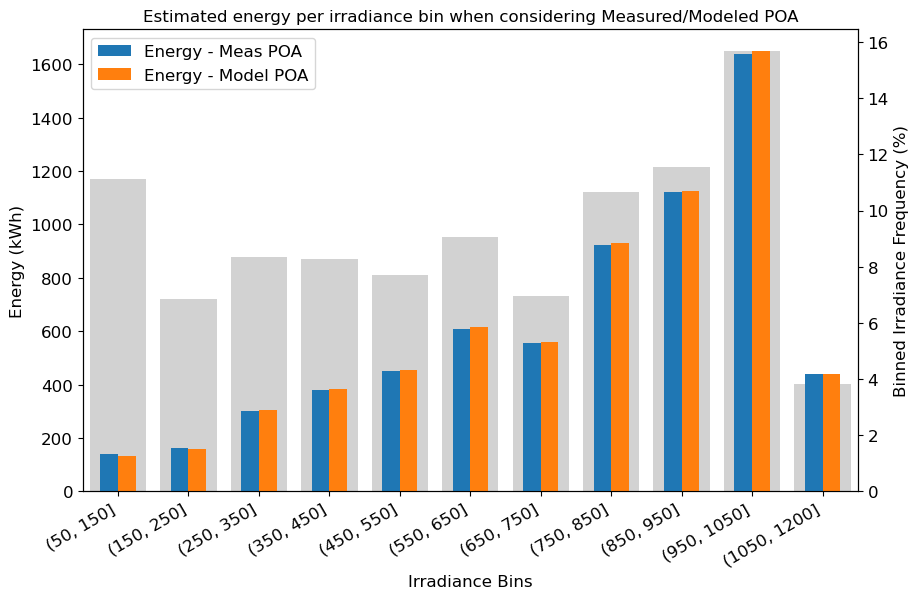

In [10]:
#we can plot the energy produced in each bin of irradiance and see where the largest differences are when using modeled/measured POA
bins['Energy - Model POA'] = df.groupby('Irradiance Bins').sum()['DC Power - Model POA']/1000
bins['Energy - Meas POA'] = df.groupby('Irradiance Bins').sum()['DC Power - Meas POA']/1000
bins = bins.sort_values('Irradiance Bins')

ax = bins.plot(x="Irradiance Bins", y=["Energy - Meas POA", "Energy - Model POA"], kind="bar", rot=0)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Energy (kWh)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, errorbar=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plt.title('Estimated energy per irradiance bin when considering Measured/Modeled POA')
plt.show()

### Analysis II: Residual Analysis
#### • Residual Analysis - quantifies the degree that variables may affect model errors
### $V_{modeled} - V_{measured}$

### Residual Distribution
Residuals should be normally distributed, otherwise this indicates a consistent bias of over or under predicting \
To get a closer look at a majority of the residuals, the outer 1% are removed using z-score. The distribution should be centered about the mean, shown by the red line

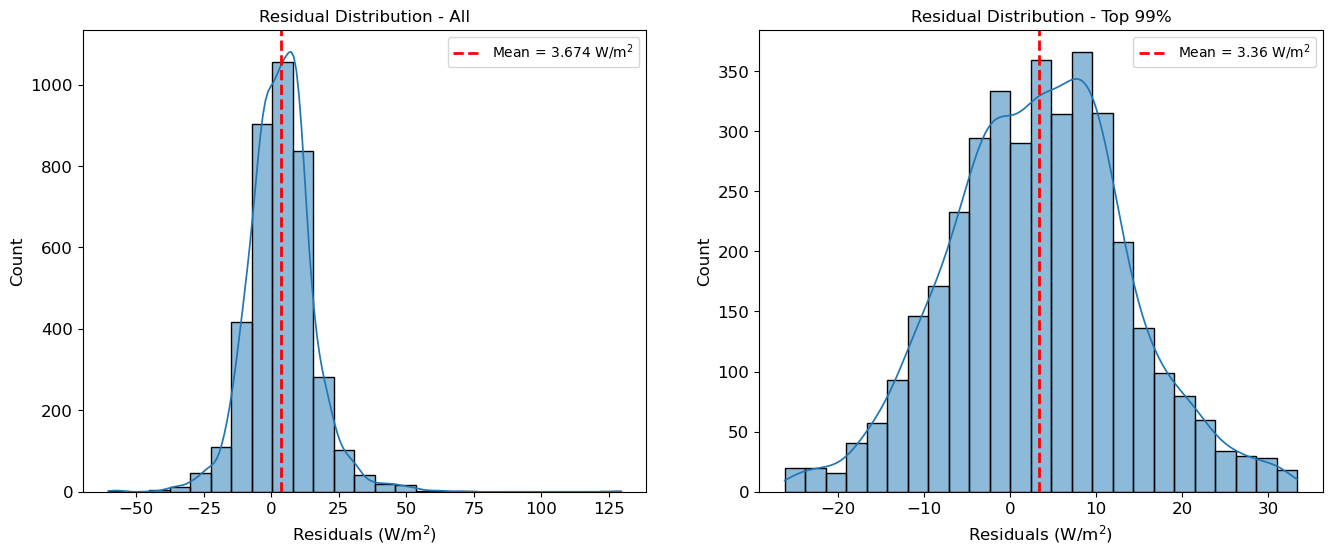

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

#find residuals
df['Residuals'] = (df['Modeled POA'] - df['Measured front POA irradiance (W/m2)'])
#plot them on histogram
hsp = sns.histplot(df['Residuals'], kde=True, bins=25, ax=ax1)
#add vertical line to show mean
ax1.axvline(x=df['Residuals'].mean(), linewidth=2, color='red',linestyle='--', label =('Mean ='+' '+str(round(df['Residuals'].mean(),3))+' W/m$^2$'))
ax1.set_title('Residual Distribution - All')
ax1.set_xlabel('Residuals (W/m$^2$)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['Residuals'].mean(),3))+' W/m$^2$'))]
ax1.legend(prop=dict(size='small'),handles=line_4)

#Use z-score to eliminate the outer 1% of residuals
df['zscore'] = scipy.stats.zscore(df['Residuals'].dropna())
df['resid_trim'] = df['Residuals'][(df['zscore'] < 2.5) & (df['zscore'] > -2.5)]
#plot them on histogram
hsp = sns.histplot(df['resid_trim'], kde=True, bins=25, ax=ax2)
#add vertical line to show mean
ax2.axvline(x=df['resid_trim'].mean(), linewidth=2, color='red',linestyle='--',label =('Mean ='+' '+str(round(df['resid_trim'].mean(),3))+' W/m$^2$'))
ax2.set_title('Residual Distribution - Top 99%')
ax2.set_xlabel('Residuals (W/m$^2$)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['resid_trim'].mean(),3))+' W/m$^2$'))]
ax2.legend(prop=dict(size='small'),handles=line_4)

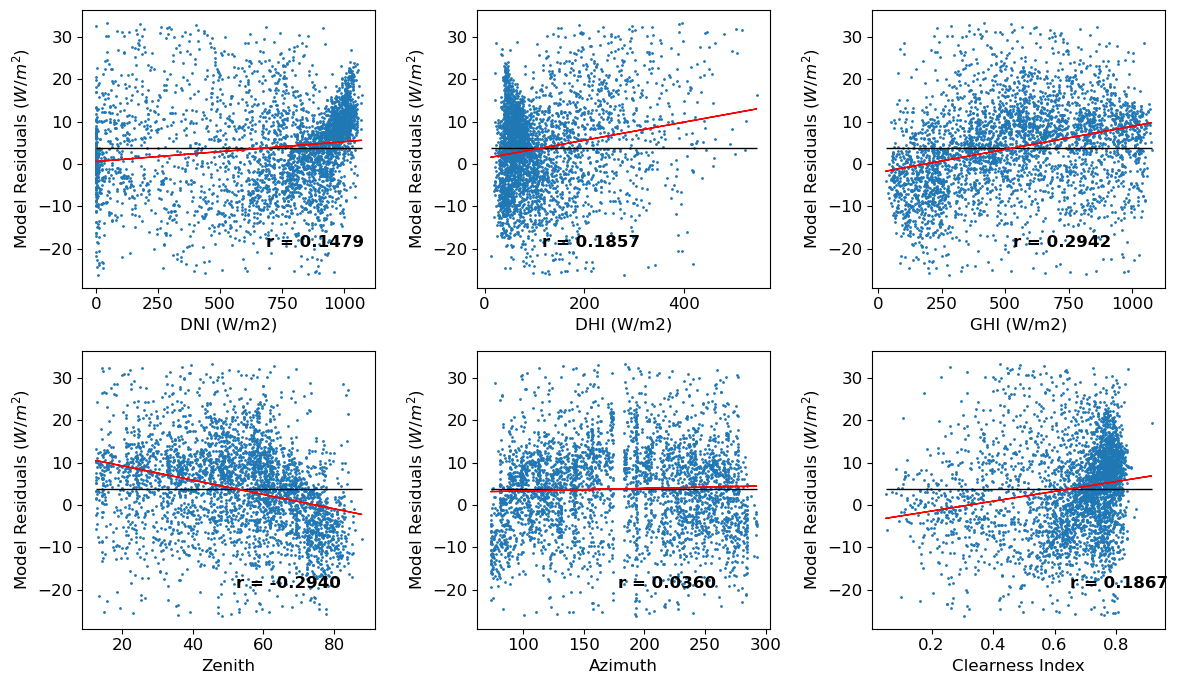

In [12]:
#plot residuals against common inputs into DNI models - high correlation could indicate a weakness in the model's consideration of that variable

df = df.dropna()
covariates = ['DNI (W/m2)', 'DHI (W/m2)', 'GHI (W/m2)','Zenith', 'Azimuth', 'Clearness Index']
y = df['resid_trim']
y_avg = df['resid_trim'].mean()
y_med = df['resid_trim'].median()

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
for covariate, ax in zip(covariates, axes.flatten()):
    x = df[covariate]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    r = np.corrcoef(x, y)[0][1]
    
    ax.scatter(x, y, s=1)
    ax.hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black', linestyles='-')
    ax.text(x=x.mean(), y=(y.min() + (-0.25*y.min())), s=f"r = {r:0.04f}", weight='bold')
    ax.plot(x, p(x), linewidth=1, color='red')
    ax.set_xlabel(covariate)
    ax.set_ylabel('Model Residuals ($W/m^2$)')

fig.tight_layout()

## Plotting residuals vs AOI with division of some metric
Plotting the residuals vs AOI helps to describe the time of day dependence

In [ ]:
add r values & trendlines

Text(0.5, 1.0, 'Residuals of Model at High and Low Clearness Index levels')

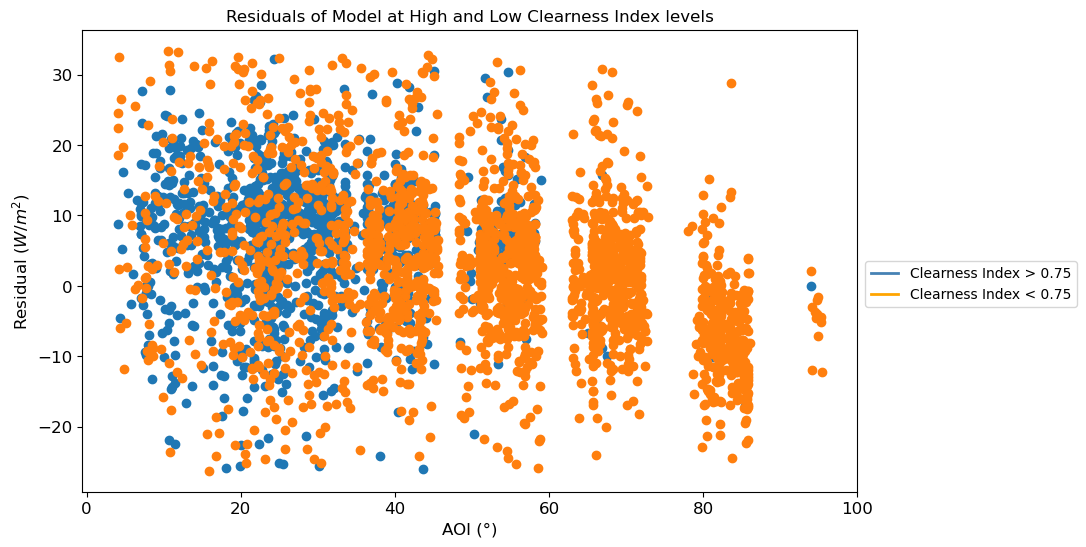

In [13]:
metric = 'Clearness Index' #<---------------- could be any value that is a column in the df (wind speed, clearness index, ambient temp)
bound = 0.75 #<------------------------------ the bound at which to separate the upper and lower categories

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

plt.scatter(x=df_h['AOI'], y=df_h['resid_trim'])
plt.scatter(x=df_l['AOI'], y=df_l['resid_trim'])

plt.ylabel('Residual ($W/m^2$)')
plt.xlabel('AOI (°)')

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label=(metric+' > '+str(bound)))
line_3 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label=(metric+' < '+str(bound)))
lines = [line_1,line_3]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('Residuals of Model at High and Low '+metric+' levels')

### Residuals by month
Grouping the residuals by month is one way to check if the model has any extreme behavior in specific seasons of the year \
This is done below with a boxplot which shows the spread of the data within the months and a jointplot which can show this and the distribution of the data across the months as well

Text(0.5, 1.0, 'Model Residuals by Month')

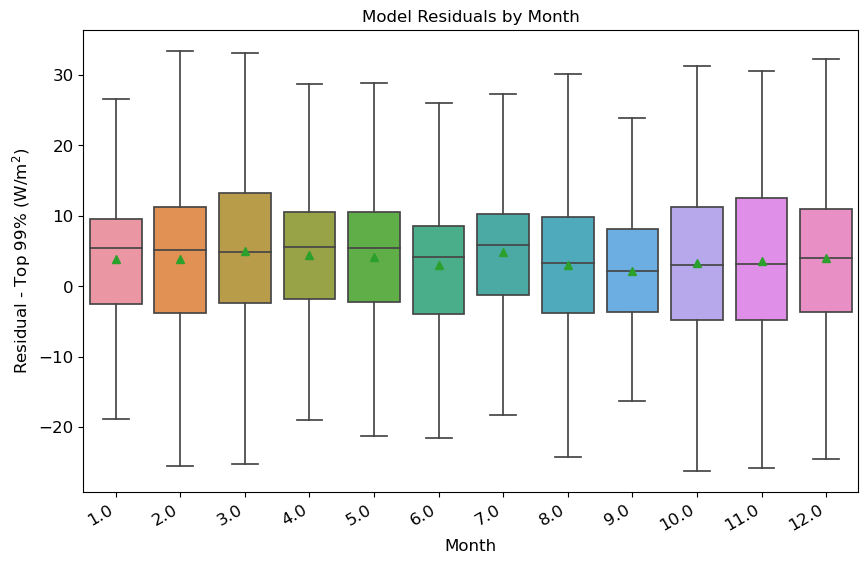

In [14]:
sns.boxplot(data=df, x='Month', y='resid_trim', showfliers=False, showmeans=True)
plt.xticks(rotation=30, ha='right')
plt.ylabel('Residual - Top 99% (W/m$^2$)')
plt.title('Model Residuals by Month')

Text(0.5, 1.0, 'title')

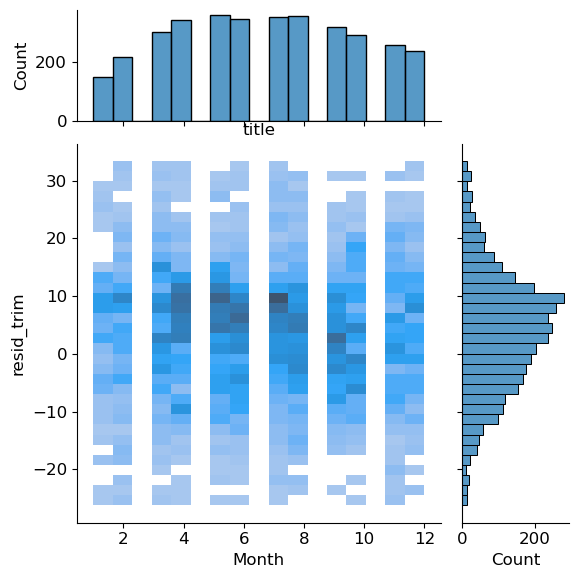

In [25]:
sns.jointplot(data=df, x='Month', y='resid_trim', kind='hist',marginal_ticks=True, dropna=True, ratio=3)

### Analemma Plots
These are another way to check seasonality of a model and can also show how the model performs at specific times of day throughout the entire year

Text(0.5, 0, 'Solar Azimuth')

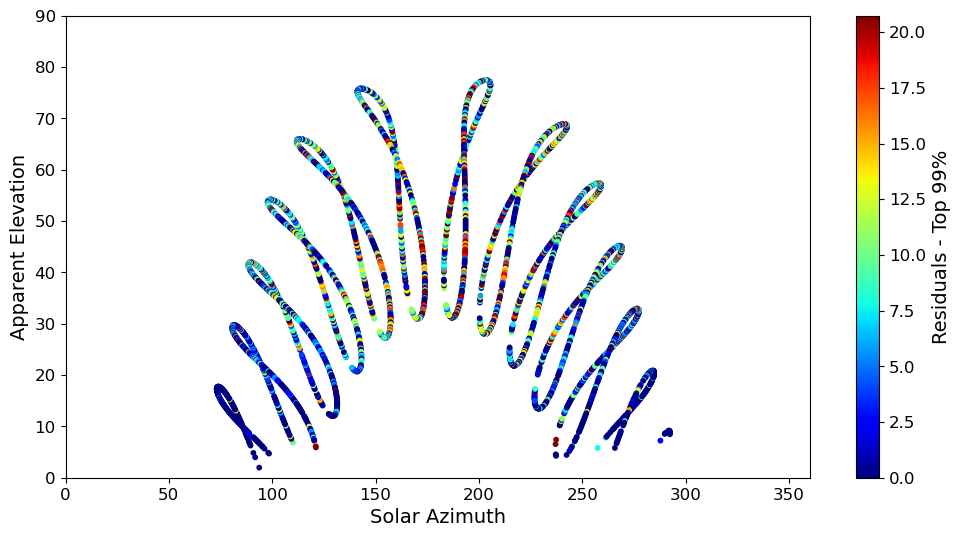

In [16]:
#analemma plots show the residuals at different times of the day/year
plt.figure(figsize=(12,6))
plt.scatter(x=df['Azimuth'], y=df['Sol Elev'], c=df['resid_trim'], cmap='jet', s=10)
clb = plt.colorbar()
clb.ax.set_ylabel('Residuals - Top 99%',fontsize =14)
plt.clim(0,(df['resid_trim'].describe()['75%'] + df['resid_trim'].describe()['std']))
plt.xlim(0,360)
plt.ylim(0,90)
plt.ylabel('Apparent Elevation', fontsize=14 )
plt.xlabel('Solar Azimuth',fontsize =14)

### Empirical Cumulative Distribution Plot (ECDF)
This plot shows the cumulative distribution of the residuals with the median as the dashed line and the mean as the solid line


In [ ]:
change 10th and 90th linestyle


Text(0.5, 1.0, 'ECDF of Model Residuals - Top 99%')

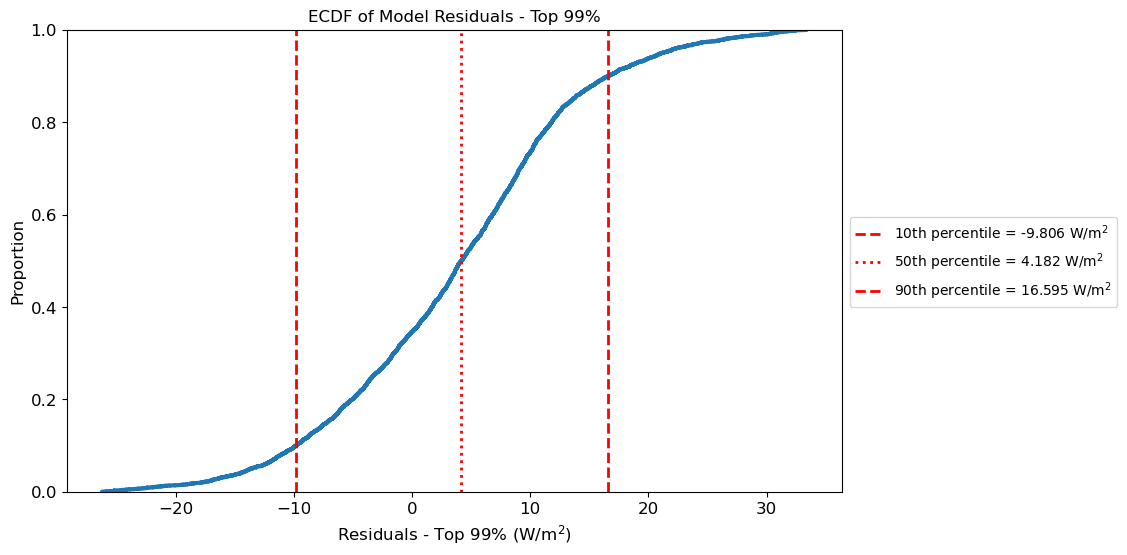

In [17]:
#plot empirical cumulative distribution functions - another way to visualize the distribution of the residuals
sns.ecdfplot(data=df, x='resid_trim', linewidth=3)
plt.xlabel('Residuals - Top 99% (W/m$^2$)')
perc10 = df['resid_trim'].quantile(0.1)
perc50 = df['resid_trim'].quantile(0.5)
perc90 = df['resid_trim'].quantile(0.9)
plt.axvline(perc10, linewidth=2, color='red', linestyle='--', label=f'10th percentile = {perc10:0.03f} W/m$^2$')
plt.axvline(perc50, linewidth=2, color='red', linestyle='dotted', label=f'50th percentile = {perc50:0.03f} W/m$^2$')
plt.axvline(perc90, linewidth=2, color='red', linestyle='--', label=f'90th percentile = {perc90:0.03f} W/m$^2$')
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4])
plt.title('ECDF of Model Residuals - Top 99%')

### Plotting ECDF of model residuals with the division of some metric

In [ ]:
find another metric

Text(0.5, 1.0, 'ECDF of Model at High and Low DNI (W/m2) levels')

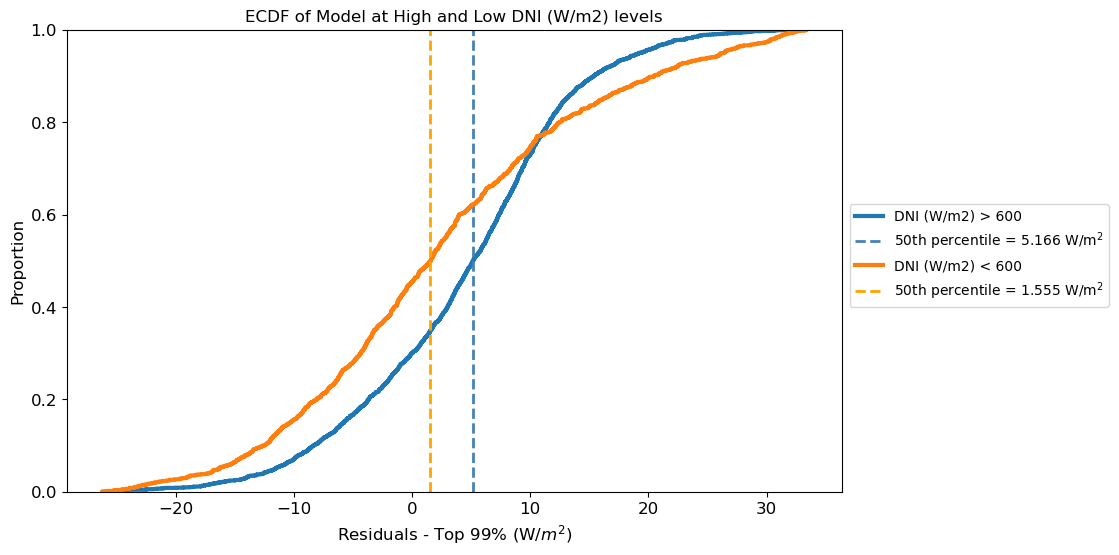

In [29]:
metric = 'DNI (W/m2)' #<---------------- could be any value that is a column in the df (wind speed, clearness index, ambient temp)
bound = 600 #<------------------------------ the bound at which to separate the upper and lower categories

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

perc50_h = df_h['resid_trim'].quantile(0.5)
perc50_l = df_l['resid_trim'].quantile(0.5)

sns.ecdfplot(data=df_h, x='resid_trim', linewidth=3, label=(metric+' > '+str(bound)))
plt.axvline(perc50_h, linewidth=2, color='steelblue', linestyle='--', label=f'50th percentile = {perc50_h:0.03f} W/m$^2$')
sns.ecdfplot(data=df_l, x='resid_trim', linewidth=3, label = (metric+' < '+str(bound)))
plt.axvline(perc50_l, linewidth=2, color='orange', linestyle='--', label=f'50th percentile = {perc50_l:0.03f} W/m$^2$')
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4])
plt.xlabel('Residuals - Top 99% (W/$m^2$)')
plt.title('ECDF of Model at High and Low '+metric+' levels')

## Analysis III: Comparison to Baseline Models
#### Comparing the model to other well-known baseline models can provide information about how the model is performing relative to accepted models. The baseline model chosen for POA transposition is the Haydavies model

In [19]:
baseline_model = 'Haydavies'
df['Baseline Model POA']  = pvlib.irradiance.get_total_irradiance(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
                    solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'],dni=df['DNI (W/m2)'],
                    ghi=df['GHI (W/m2)'], dhi=df['DHI (W/m2)'], dni_extra=spdf['dni_extra'], model =baseline_model)['poa_global']

#calculate some basic error metrics - like NBE & Model Residuals
df['Baseline Residuals'] = df['Baseline Model POA'] - df['Measured front POA irradiance (W/m2)']
df['Baseline NBE'] = 100 * (df['Baseline Model POA'] - df['Measured front POA irradiance (W/m2)'])/(df['Measured front POA irradiance (W/m2)'])

In [20]:
#using modeled POA to estimate energy to use in an energy yield analysis - again normally the model would be using effective irradiance but for an even comparison with measured data we are using POA.
df['DC Power - Baseline Model POA'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Baseline Model POA'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], df['Modeled POA'], deltaT=3),
                                    pdc0=275, gamma_pdc=-0.0041)
#find overall % diff for annual energy
print('With initial model POA, predicted annual energy is', round(df['DC Power - Model POA'].sum()/1000,3),
      'kWh and with baseline modeled POA, predicted annual energy is', round(df['DC Power - Baseline Model POA'].sum()/1000,3), 'kWh')
print('The % difference in energy estimate when using baseline vs modeled POA is ', round(((df['DC Power - Baseline Model POA'].sum()-df['DC Power - Model POA'].sum())/df['DC Power - Model POA'].sum())*100,3),'%')

With initial model POA, predicted annual energy is 6558.366 kWh and with baseline modeled POA, predicted annual energy is 6560.715 kWh
The % difference in energy estimate when using baseline vs modeled POA is  0.036 %


Text(0.5, 1.0, 'Residuals for Model & Baseline Model')

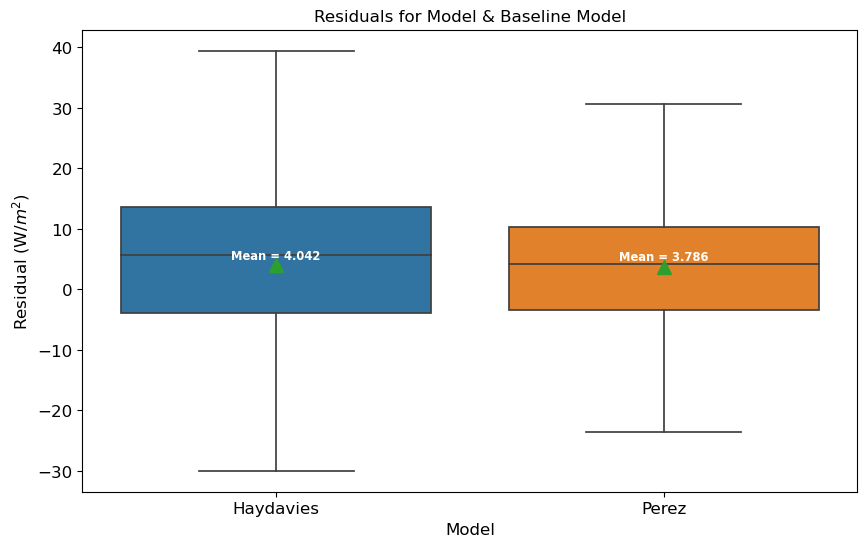

In [21]:
#put the model and baseline model residuals in one df for easy analysis
resid_df = pd.concat([
    pd.DataFrame({'Residual': df['Baseline Model POA'] - df['Measured front POA irradiance (W/m2)'], 'Model': baseline_model,}),
    pd.DataFrame({'Residual': df['Modeled POA'] - df['Measured front POA irradiance (W/m2)'],'Model':model_name ,})
], ignore_index=True)

box_plot = sns.boxplot(x='Model', y='Residual', data=resid_df, showfliers=False, showmeans=True, meanprops={'markersize':10})
plt.ylabel('Residual (W/$m^2$)')
#view the numerical value of mean on plot
means = resid_df.groupby(['Model'])['Residual'].mean()
vertical_offset = resid_df['Residual'].mean() * 0.25 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,means[xtick] + vertical_offset,('Mean = '+str(round(means[xtick],3))),horizontalalignment='center',size='x-small',color='w',weight='semibold')
plt.title('Residuals for Model & Baseline Model')

Text(0.5, 1.0, 'ECDF of Model & Baseline Model Residuals')

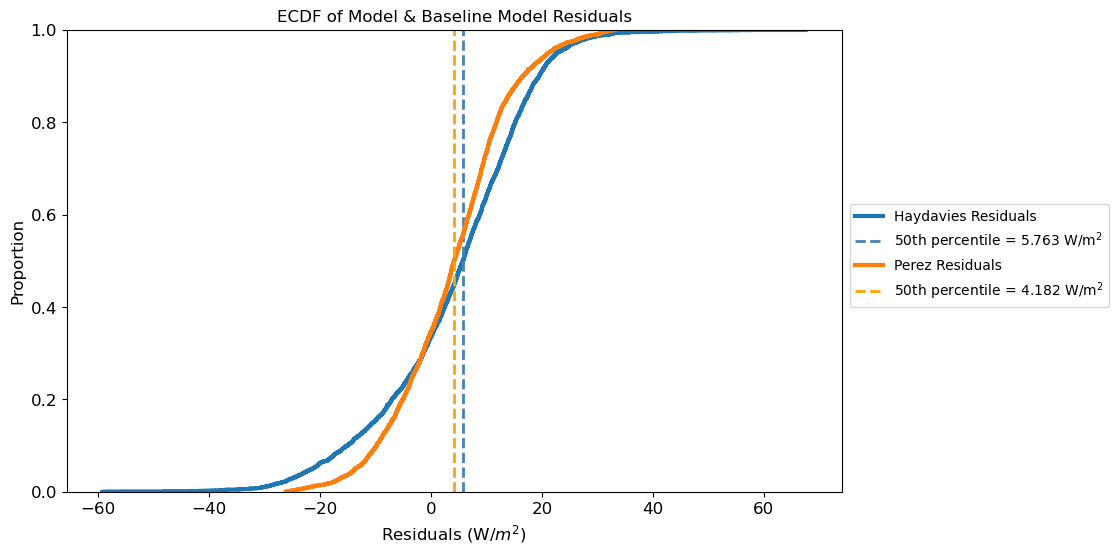

In [22]:
#ecdf of the two models overlayed & p50 for each

perc50_m = np.percentile(df['Residuals'].dropna(), 50)
perc50_b = np.percentile(df['Baseline Residuals'].dropna(), 50)

sns.ecdfplot(data=df, x='Baseline Residuals', linewidth=3, label = (baseline_model+' Residuals'))
plt.axvline(x=perc50_b, linewidth=2, color='steelblue', linestyle='--', label=f'50th percentile = {perc50_b:0.03f} W/m$^2$')
sns.ecdfplot(data=df, x='Residuals', linewidth=3, label=(model_name+' Residuals'))
plt.axvline(x=perc50_m, linewidth=2, color='orange', linestyle='--', label=f'50th percentile = {perc50_m:0.03f} W/m$^2$')
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4])
plt.xlabel('Residuals (W/$m^2$)')
plt.title('ECDF of Model & Baseline Model Residuals')

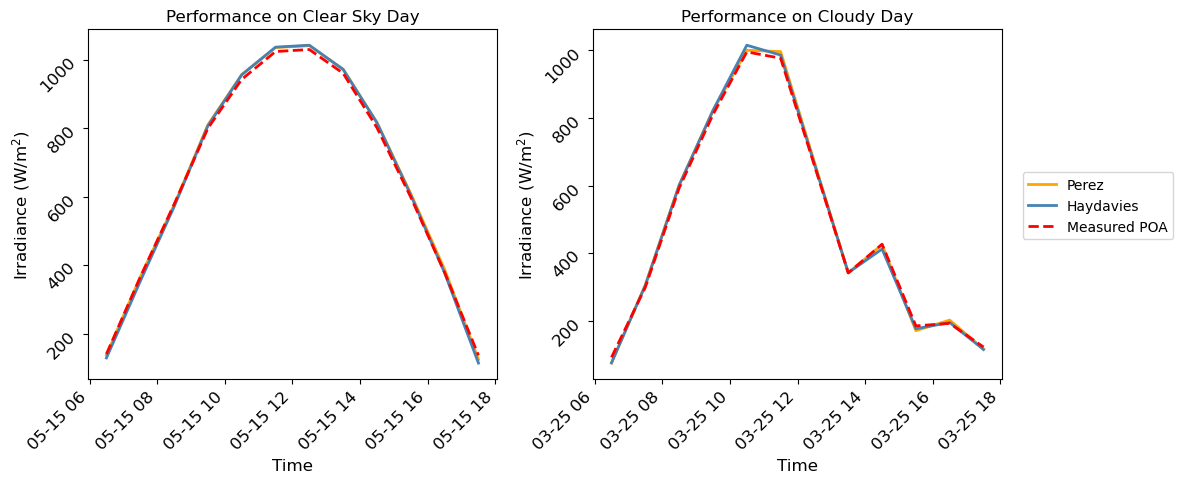

In [23]:
# diurnal plots help visualize the differences between modeled and measured POA as well as model and baseline model POA performance

dates = [('Clear Sky', '2021-05-15'),('Cloudy', '2021-03-25'),]

fig, axes = plt.subplots(1, len(dates), figsize=(12,5))

for (sky_condition, date), ax in zip(dates, axes):
    df.loc[date, 'Modeled POA'].plot(ax=ax, linewidth=2, color='orange', label = model_name)
    df.loc[date, 'Baseline Model POA'].plot(ax=ax, linewidth=2, color='steelblue',label = baseline_model)
    df.loc[date, 'Measured front POA irradiance (W/m2)'].plot(ax=ax, linewidth=2, linestyle='dashed', color='red', label = 'Measured POA')
    ax.tick_params(labelrotation = 45)
    ax.set_ylabel('Irradiance (W/m$^2$)')
    ax.set_xlabel('Time')
    ax.set_title(f'Performance on {sky_condition} Day')

axes[-1].legend(prop=dict(size='small'), loc=[1.05, 0.4])
fig.tight_layout()

Text(0.5, 1.0, 'NMBE (%) of models in different irradiance bins')

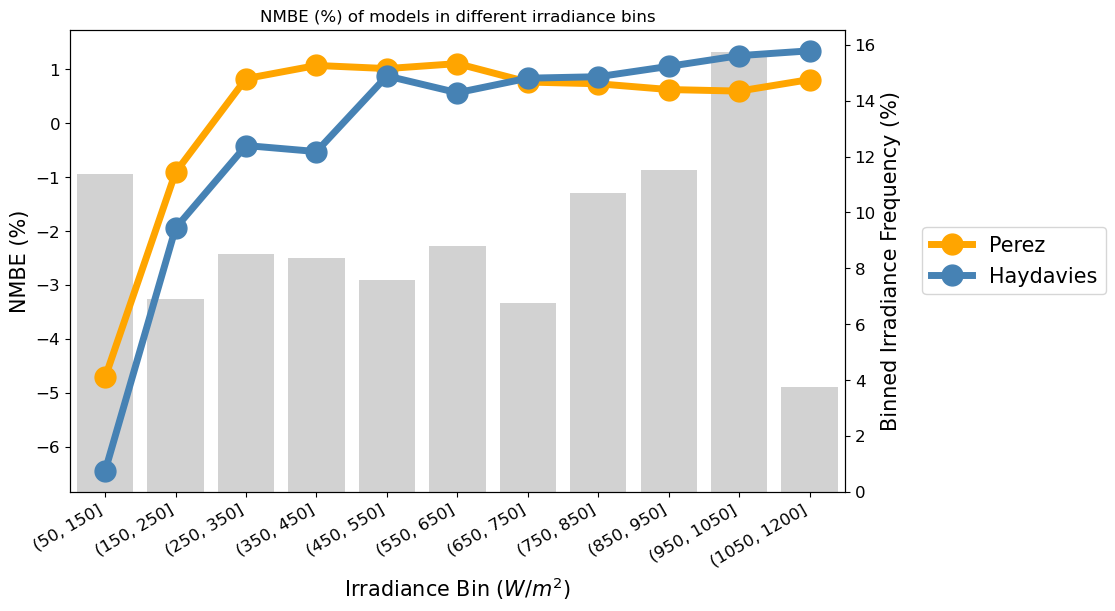

In [30]:
#view the model and baseline model performance at different levels of irradiance

df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins.rename(columns = {'count' : 'Frequency'}, inplace = True)
bins['Irradiance Bins'] = bins.index
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
y = df[['Irradiance Bins','NBE']].groupby('Irradiance Bins').mean()['NBE']
ax.plot(x, y, 'orange', marker='o', zorder=6.5, linewidth=5, markersize=15)
y = df[['Irradiance Bins','Baseline NBE']].groupby('Irradiance Bins').mean()['Baseline NBE']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=5, markersize=15)
plt.xticks(rotation=30, ha='right')

ax.set_ylabel('NMBE (%)', fontsize=15)
ax.set_xlabel('Irradiance Bin ($W/m^2$)', fontsize=15)
ax.legend([model_name,baseline_model],loc='center right',bbox_to_anchor=(1.35, 0.5), fontsize=15)

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, errorbar=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)', fontsize=15)
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
plt.title('NMBE (%) of models in different irradiance bins')